# QOSF screening task 4 - Decomposition

### This notebook will show you how to work with Qiskit's transpilation capabilities in order to generate hardware-compliant quantum circuits for a given statevector, with a depth less than 50, using the basis gates=[x,h,rz,cx] and the given architecture.


In [1]:
# import of required libraries and modules
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)

from qiskit import transpile, QuantumCircuit
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity, Statevector, DensityMatrix
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import RZGate, XGate, HGate, CXGate
from qiskit.circuit.library import UnitaryGate
# transpiler passes
from qiskit.transpiler.passes.layout import csp_layout, dense_layout, sabre_layout, vf2_layout, trivial_layout
# Routing pa″sses
from qiskit.transpiler.passes.routing import basic_swap, lookahead_swap, sabre_swap, stochastic_swap, star_prerouting
# Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis import basis_translator
from qiskit.transpiler.passes.synthesis import unitary_synthesis, high_level_synthesis
# Optimization passes
from qiskit.transpiler.passes.optimization import commutative_cancellation, consolidate_blocks, collect_2q_blocks, collect_1q_runs

### Transpilation

Transpilation transforms a (potentially abstract) quantum computation to a *physical* quantum circuit that is compliant to a given quantum computer, i.e. can directly be executed by a suitable device (also called an [ISA circuit](https://www.ibm.com/quantum/blog/isa-circuits)).
In order to yield a hardware-compliant quantum circuit, transpilation must define for each time step which physical resource of a quantum computer is performing what computation while considering that typically only a subset of qubits can interact in a specific way.
This process is divided into two tasks:
* Synthesis translates the quantum gates in an input quantum circuit to the set of quantum gates supported by the target quantum computer. The set of quantum gates supported by a target quantum computer is also called *basis gate set*. 
* Routing assigns the qubits of a quantum circuit to the qubits of a quantum computer in each time step. Whenever the qubit assignment changes, additional operations such as swap gates must be inserted into the quantum circuit. When the target quantum computer has a restricted *qubit connectivity*, the qubit assignment must change often to ensure that each quantum gate is only performed on qubits that are connected, i.e. qubits that can interact with each other. 

The transpilation process additionally optimizes the physical quantum circuit to increase the probability of obtaining the correct result.
This optimization step typically improves *characteristics* such as the size or duration of a physical quantum circuit given e.g. in number of quantum gates.

Let us now generate the statevector provided. 

In [2]:
import numpy as np
size = 5
state_values = [22,17,27,12]
state_vector = [0]*2**size
for s in state_values:
   print(np.binary_repr(s,size))
   state_vector[s] = 0.5
statevector = np.asarray(state_vector)

10110
10001
11011
01100


Let us then construct the corresponding circuit.

In [3]:
circuit = QuantumCircuit(5)
state = Statevector(statevector)
mat = DensityMatrix(state)
print(mat.probabilities_dict(qargs=None, decimals=None))

{'01100': 0.25, '10001': 0.25, '10110': 0.25, '11011': 0.25}


In [4]:
def STATE_PREP():
    qc = QuantumCircuit(5)
    qc.h(0)
    qc.h(1)
    qc.x(2)
    qc.cx(0,2)
    qc.cx(1,2)
    qc.cx(2,3)
    qc.cx(1,2)
    qc.x(4)
    qc.ccx(2,3,4)
    return qc

qc = STATE_PREP()
DensityMatrix(qc).probabilities_dict(qargs=None, decimals=None)

{'01100': 0.24999999999999992,
 '10001': 0.24999999999999992,
 '10110': 0.24999999999999992,
 '11011': 0.24999999999999992}

The function `get_qc_characteristics` should be defined that determines relevant characterstics of a quantum circuit such the number of qubits required by a quantum circuit (to be stored in the variable `num_qubits`), the number and type of quantum gates (to be stored in the variable `ops`), the depth of a quantum circuit (to be stored in the variable `depth`) and the number of multi-qubit operations (to be stored in the variable `num_multi_qubit_ops`).
The depth of a quantum circuit indicates the time required to executed a quantum circuit on a quantum computer and is defined as the longest chain of quantum gates from the start to the end of a quantum circuit that need to be computed consecutively.

In [5]:
def get_qc_characteristics(qc):
    depth =  qc.depth()
    num_qubits = qc.num_qubits    
    ops = dict(qc.count_ops())
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    return {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}


In [6]:
# print quantum circuit characteristics
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])
    
print_qc_characteristics(qc)

Quantum circuit characteristics
  Depth: 6
  Number of qubits: 5
  Operations: {'cx': 4, 'h': 2, 'x': 2, 'ccx': 1}
  Number of multi-qubit Operations: 5


This quantum circuit is not hardware-compliant, e.g., the ccx gate is not allowed.
Instead, such an operation must be translated to the basis gate set of the target quantum computer.


We can go one step further and examine Qiskit's standard decomposition:

In [7]:
qc_dec = qc.decompose()
get_qc_characteristics(qc_dec)

{'depth': 14,
 'num_qubits': 5,
 'ops': {'cx': 10, 't': 4, 'tdg': 3, 'u2': 2, 'u3': 2, 'h': 2},
 'num_multi_qubit_ops': 10}

In [8]:
qc_dec.draw(fold=-1)

┌─────────┐                                                                        
q_0: ─┤ U2(0,π) ├───■────────────────────────────────────────────────────────────────────
      ├─────────┤   │                                                                    
q_1: ─┤ U2(0,π) ├───┼────■─────────■─────────────────────────────────────────────────────
     ┌┴─────────┴┐┌─┴─┐┌─┴─┐     ┌─┴─┐                                        ┌───┐      
q_2: ┤ U3(π,0,π) ├┤ X ├┤ X ├──■──┤ X ├─────────■─────────────────────■────■───┤ T ├───■──
     └───────────┘└───┘└───┘┌─┴─┐└───┘         │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
q_3: ───────────────────────┤ X ├──■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├
     ┌───────────┐┌───┐     └───┘┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘
q_4: ┤ U3(π,0,π) ├┤ H ├──────────┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
     └───────────┘└───┘          └───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘

However, this default decomposition contains some gate operations which are not allowed neither.

Let us instead set the target basis set as well as the qubit connectivity.

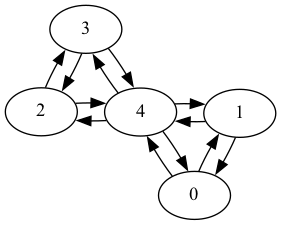

In [9]:
target = Target(num_qubits=5)
target.add_instruction(CXGate(), 
    {
        (0, 1): InstructionProperties(error=.0001, duration=5e-7), 
        (1, 4): InstructionProperties(error=.0001, duration=5e-7),
        (0, 4): InstructionProperties(error=.0001, duration=5e-7),
        (2, 3): InstructionProperties(error=.0001, duration=5e-7),
        (4, 3): InstructionProperties(error=.0001, duration=5e-7),
        (4, 2): InstructionProperties(error=.0001, duration=5e-7),
        (2, 4): InstructionProperties(error=.0001, duration=5e-7),
        (1, 0): InstructionProperties(error=.0001, duration=5e-7), 
        (4, 1): InstructionProperties(error=.0001, duration=5e-7),
        (4, 0): InstructionProperties(error=.0001, duration=5e-7),
        (3, 2): InstructionProperties(error=.0001, duration=5e-7),
        (3, 4): InstructionProperties(error=.0001, duration=5e-7),
    }
)

target.add_instruction(
    RZGate(Parameter('theta')),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.add_instruction(
    XGate(),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.add_instruction(
    HGate(),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.build_coupling_map().draw()

In [10]:
# transpile the quantum circuit for the basis gate of our example backend
qc_synth = generate_preset_pass_manager(0, target=target, seed_transpiler=42).run(qc)
qc_synth.draw(fold=-1)

global phase: 15π/8
         ┌───┐                                                                                                                           
q_0 -> 0 ┤ H ├─────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────
         ├───┤                 │                                                                                                         
q_1 -> 1 ┤ H ├─────────────────┼─────────■─────────■─────────────────────────────────────────────────────────────────────────────────────
         ├───┤┌───┐     ┌───┐  │  ┌───┐  │         │  ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐   ┌───┐         
q_2 -> 2 ┤ X ├┤ X ├──■──┤ X ├──┼──┤ H ├──┼─────────┼──┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├───┤ H ├─────────
         └───┘└─┬─┘  │  └─┬─┘  │  └───┘  │  ┌───┐  │  └─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘├─────────┬┘└─┬─┘└──┬───┬──┘┌──┴───┴───┐┌───┐
q_3 -> 3 ───────┼────┼────┼────┼─────────┼──┤ X ├──┼────■────────────────┼───────────────■──┤ Rz(π/4) ├───┼─────┤ X ├───┤ Rz(-π/4) ├┤ X ├
         ┌───┐  │  ┌─┴─┐  │  ┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐                   │                  └─────────┘   │     └─┬─┘   ├─────────┬┘└─┬─┘
q_4 -> 4 ┤ X ├──■──┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├───────────────────■────────────────────────────────■───────■─────┤ Rz(π/4) ├───■──
         └───┘     └───┘     └───┘     └───┘     └───┘                                                                  └─────────┘

Now we are talking!

In [11]:
get_qc_characteristics(qc_synth)

{'depth': 17,
 'num_qubits': 5,
 'ops': {'cx': 13, 'rz': 7, 'h': 4, 'x': 2},
 'num_multi_qubit_ops': 13}

similarly, we can use the customized backend to compile the circuit, which will be used later.

In [12]:
cm = CouplingMap([[0, 1], [0, 4], [1, 4], [1, 0], [4, 0], [4, 1], [2, 3], [3, 2], [2, 4], [4, 2], [4, 3], [3, 4]])
backend = GenericBackendV2(num_qubits=5, basis_gates=["rz", "h", "x", "cx"], coupling_map=cm)
print("Supported basis gates:", backend.operation_names)

Supported basis gates: ['rz', 'h', 'x', 'cx', 'reset', 'delay', 'measure']


uncomment the following code to see the same compilation, but with the backend approach.

In [13]:
# qc_synth_backend = generate_preset_pass_manager(0, backend=backend, seed_transpiler=42).run(qc)
# qc_synth_backend.draw(fold=-1)

In [14]:
# get_qc_characteristics(qc_synth_backend)

We will now create our own transpiler solely by using Qiskit's customizable and extensible transpilation infrastructure.

The transpilation in Qiskit is organized in stages that each are expected to solve one particular task. As Qiskit is applied to a variety of quantum circuits that each exhibit different structures, Qiskit's default transpilation used in the previous section must perform well on an arbitrary quantum circuit. 

In [15]:
pm_staged = StagedPassManager()
# replace the operation with its decomposition in two-qubit gates
# pm_staged.init = generate_unroll_3q(None)
# initialize the layout stage with an empty pass manager
pm_staged.layout = PassManager()
# set a 'trivial' initial layout, i.e. each qubit in the quantum circuit with index i 
# is mapped to the physical qubit on a device with the same index
pm_staged.layout += trivial_layout.TrivialLayout(cm)

# do not modify the next line
pm_staged.layout += generate_embed_passmanager(cm)

In [16]:
pm_staged.routing = PassManager(sabre_layout.SabreLayout(cm))
# pm_staged.routing = PassManager(sabre_swap.SabreSwap(cm))
pm_staged.translation = PassManager(basis_translator.BasisTranslator(SessionEquivalenceLibrary, backend.operation_names))
qc_routed_synth = pm_staged.run(qc)
print_qc_characteristics(qc_routed_synth)
qc_routed_synth.draw(fold=-1)

Quantum circuit characteristics
  Depth: 14
  Number of qubits: 5
  Operations: {'cx': 10, 'rz': 7, 'h': 4, 'x': 2}
  Number of multi-qubit Operations: 10


global phase: π/8
         ┌───┐                                                                                                                 
q_0 -> 0 ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────
         ├───┤       │                                                                                                         
q_1 -> 1 ┤ H ├───────┼────■─────────■──────────────────────────────────────────────────────────────────────────────────────────
         └───┘       │    │  ┌───┐  │                                        ┌─────────┐                 ┌───┐┌──────────┐┌───┐
q_3 -> 2 ────────────┼────┼──┤ X ├──┼────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├
         ┌───┐┌───┐  │    │  └─┬─┘  │  ┌─┴─┐┌──────────┐┌───┐┌─────────┐┌─┴─┐├─────────┴┐┌───┐┌─────────┐└─┬─┘└──┬───┬───┘└─┬─┘
q_4 -> 3 ┤ X ├┤ H ├──┼────┼────┼────┼──┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──
         ├───┤└───┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐└───┘└──────────┘└─┬─┘└─────────┘└───┘└──────────┘└─┬─┘└─────────┘  │  ┌──┴───┴──┐   │  
q_2 -> 4 ┤ X ├─────┤ X ├┤ X ├──■──┤ X ├───────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■──
         └───┘     └───┘└───┘     └───┘                                                                       └─────────┘

This basically reproduce the preset pass manager. (print out again below)

In [17]:
qk_qc = generate_preset_pass_manager(0, backend=backend, seed_transpiler=42).run(qc)
print_qc_characteristics(qk_qc)

Quantum circuit characteristics
  Depth: 17
  Number of qubits: 5
  Operations: {'cx': 13, 'rz': 7, 'h': 4, 'x': 2}
  Number of multi-qubit Operations: 13


#### Impact of Quantum Circuit Size on Incurred Errors During Execution

On a real device, this difference in size can make the difference between a successful quantum circuit execution and an erroneous output.
We can approximate the noise in real devices in Qiskit to check the difference between Qiskit's default transpiler and our transpiler as quantified by the Hellinger fidelity:

In [18]:
def noisy_sim(qc, backend):
    # We add measurement operations to the input quantum circuit and then run it on the specified backend
    # A GenericBackendV2 automatically constructs a default model of the expected noise processes, 
    # so backend.run would return noisy simulation results    
    return backend.run(qc.measure_all(inplace=False), shots=10*1024).result().get_counts()

own_transpiler_sim = noisy_sim(qc_routed_synth, backend)
qiskit_transpiler_sim = noisy_sim(transpile(qc.decompose(gates_to_decompose=['rz','cx','h','x']), backend=backend), backend)
reference_sim = noisy_sim(qc, GenericBackendV2(num_qubits=5))
reduction_ratio = round(
    100
    - 100
    * (get_qc_characteristics(qc_routed_synth)["num_multi_qubit_ops"] / get_qc_characteristics(qk_qc)["num_multi_qubit_ops"]),
    3,
)
print("Reduction in two-qubit gates compared to qiskit {}%!".format(reduction_ratio))
print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))

Reduction in two-qubit gates compared to qiskit 23.077%!
Own transpiler fidelity 0.1387
Qiskit transpiler fidelity 0.2408


Well, for some reason the transpiler is not robust against the noise. But at least it is better (most of the time) than the default transpiler. We can also test other routing and layout method. Below we use basic swap to increase the fidelity at the cost of a little bit circuit depth.

### Routing

In [19]:
pm_staged.routing = PassManager(basic_swap.BasicSwap(cm))
# pm_staged.routing = PassManager(sabre_swap.SabreSwap(cm))
pm_staged.translation = PassManager(basis_translator.BasisTranslator(SessionEquivalenceLibrary, backend.operation_names))
qc_routed_synth_basic = pm_staged.run(qc)
print_qc_characteristics(qc_routed_synth_basic)
qc_routed_synth_basic.draw(fold=-1)

Quantum circuit characteristics
  Depth: 20
  Number of qubits: 5
  Operations: {'cx': 16, 'rz': 7, 'h': 4, 'x': 2}
  Number of multi-qubit Operations: 16


global phase: π/8
         ┌───┐     ┌───┐     ┌───┐┌───┐                    ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐   ┌───┐         
q_0 -> 0 ┤ H ├──■──┤ X ├──■──┤ X ├┤ H ├────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├───┤ H ├─────────
         ├───┤  │  └─┬─┘  │  └───┘└───┘┌───┐               └─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘   └───┘         
q_1 -> 1 ┤ H ├──┼────┼────┼─────────■──┤ X ├──■──────────────┼────────────────┼───────────────┼────────────────┼──────────────────────────────
         ├───┤  │    │    │  ┌───┐  │  └─┬─┘  │  ┌───┐       │     ┌───┐      │               │                │             ┌─────────┐      
q_2 -> 2 ┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──┤ X ├──■────┼─────┤ X ├──────■───────────────┼────────────────■───────■─────┤ Rz(π/4) ├───■──
         └───┘  │    │    │  └─┬─┘  │    │    │  └─┬─┘┌─┴─┐  │     └─┬─┘                      │  ┌─────────┐         ┌─┴─┐   ├─────────┴┐┌─┴─┐
q_3 -> 3 ───────┼────┼────┼────┼────┼────┼────┼────┼──┤ X ├──■───────┼────────────────────────■──┤ Rz(π/4) ├─────────┤ X ├───┤ Rz(-π/4) ├┤ X ├
              ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  └───┘          │                           └─────────┘         └───┘   └──────────┘└───┘
q_4 -> 4 ─────┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■─────────────────■────────────────────────────────────────────────────────────────────────
              └───┘     └───┘     └───┘     └───┘

In [20]:
own_transpiler_sim_basic = noisy_sim(qc_routed_synth_basic, backend)
increase_ratio = round(
    100
    * (round(hellinger_fidelity(own_transpiler_sim_basic, reference_sim), 4) / round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4)),
    3,
)
print("Increase in fidelity compared to qiskit {}%!".format(increase_ratio))
print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim_basic, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))

Increase in fidelity compared to qiskit 134.842%!
Own transpiler fidelity 0.3247
Qiskit transpiler fidelity 0.2408


### Layout

We can try something like denselayout below. The depth is smaller, the fidelity decreseas though.

In [21]:
# csp_layout, dense_layout, sabre_layout, vf2_layout, trivial_layout
pm_staged = StagedPassManager()
pm_staged.layout = PassManager()
pm_staged.layout += trivial_layout.TrivialLayout(cm)
pm_staged.layout += dense_layout.DenseLayout(cm)
pm_staged.layout += generate_embed_passmanager(cm)

pm_staged.routing = PassManager(basic_swap.BasicSwap(cm))
# pm_staged.routing = PassManager(sabre_swap.SabreSwap(cm))
pm_staged.translation = PassManager(basis_translator.BasisTranslator(SessionEquivalenceLibrary, backend.operation_names))
qc_routed_synth_lay = pm_staged.run(qc)
print_qc_characteristics(qc_routed_synth_lay)
qc_routed_synth_lay.draw(fold=-1)

Quantum circuit characteristics
  Depth: 14
  Number of qubits: 5
  Operations: {'cx': 10, 'rz': 7, 'h': 4, 'x': 2}
  Number of multi-qubit Operations: 10


global phase: π/8
         ┌───┐┌───┐          ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐   ┌───┐         
q_4 -> 0 ┤ X ├┤ H ├──────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├───┤ H ├─────────
         └───┘└───┘     ┌───┐└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘├─────────┬┘└─┬─┘└──┬───┬──┘┌──┴───┴───┐┌───┐
q_3 -> 1 ───────────────┤ X ├──■────────────────┼───────────────■──┤ Rz(π/4) ├───┼─────┤ X ├───┤ Rz(-π/4) ├┤ X ├
         ┌───┐          └─┬─┘                   │                  └─────────┘   │     └─┬─┘   └──────────┘└─┬─┘
q_1 -> 2 ┤ H ├───────■────┼────■────────────────┼────────────────────────────────┼───────┼───────────────────┼──
         ├───┤       │    │    │                │                                │       │                   │  
q_0 -> 3 ┤ H ├──■────┼────┼────┼────────────────┼────────────────────────────────┼───────┼───────────────────┼──
         ├───┤┌─┴─┐┌─┴─┐  │  ┌─┴─┐              │                                │       │     ┌─────────┐   │  
q_2 -> 4 ┤ X ├┤ X ├┤ X ├──■──┤ X ├──────────────■────────────────────────────────■───────■─────┤ Rz(π/4) ├───■──
         └───┘└───┘└───┘     └───┘                                                             └─────────┘

In [22]:
own_transpiler_sim_lay = noisy_sim(qc_routed_synth_lay, backend)

print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim_lay, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))

Own transpiler fidelity 0.114
Qiskit transpiler fidelity 0.2408


## Proceed to any initial state!

In [23]:
def generate_circuit(size=5, state_values=[22,17,27,12]):
    assert 2**size > any(state_values)
    state_vector = [0]*2**size
    for s in state_values:
        state_vector[s] = 1
    statevector = np.asarray(state_vector)
    norm_state = statevector/np.linalg.norm(statevector)
    # construct the unitary that map state \000...000> to the one given
    def create_unitary(v):
        dim = v.size
        # Return identity if v is a multiple of e1
        if v[0] and not np.any(v[1:]):
            return np.identity(dim)
        e1 = np.zeros(dim)
        e1[0] = 1
        w = v/np.linalg.norm(v) - e1
        return np.identity(dim) - 2*(np.tensordot(w, w, axes=0)/(np.dot(w, w.T)))

    Dmat = create_unitary(norm_state.T)
    # check if it is a unitary
    # print(DensityMatrix(Dmat).to_operator().is_unitary())
    operator = DensityMatrix(Dmat).to_operator()
    any_circ = QuantumCircuit(size)
    gate = UnitaryGate(operator)
    any_circ.append(gate, range(size)) 
    return any_circ

In [34]:
circ = generate_circuit()

# you can also change the coupling as well as the gate set here

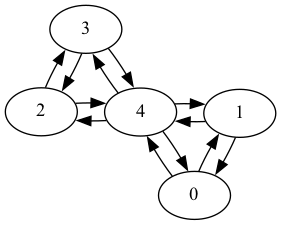

In [26]:
target = Target(num_qubits=5)
target.add_instruction(CXGate(), 
    {
        (0, 1): InstructionProperties(error=.0001, duration=5e-7), 
        (1, 4): InstructionProperties(error=.0001, duration=5e-7),
        (0, 4): InstructionProperties(error=.0001, duration=5e-7),
        (2, 3): InstructionProperties(error=.0001, duration=5e-7),
        (4, 3): InstructionProperties(error=.0001, duration=5e-7),
        (4, 2): InstructionProperties(error=.0001, duration=5e-7),
        (2, 4): InstructionProperties(error=.0001, duration=5e-7),
        (1, 0): InstructionProperties(error=.0001, duration=5e-7), 
        (4, 1): InstructionProperties(error=.0001, duration=5e-7),
        (4, 0): InstructionProperties(error=.0001, duration=5e-7),
        (3, 2): InstructionProperties(error=.0001, duration=5e-7),
        (3, 4): InstructionProperties(error=.0001, duration=5e-7),
    }
)

target.add_instruction(
    RZGate(Parameter('theta')),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.add_instruction(
    XGate(),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.add_instruction(
    HGate(),
    {
        (1,): InstructionProperties(error=.00001, duration=5e-8),
        (2,): InstructionProperties(error=.00001, duration=5e-8),
        (3,): InstructionProperties(error=.00001, duration=5e-8),
        (4,): InstructionProperties(error=.00001, duration=5e-8),
        (0,): InstructionProperties(error=.00001, duration=5e-8)
    }
)

target.build_coupling_map().draw()

In [36]:
# transpile the quantum circuit for the basis gate of our example backend
custom_qc_synth = generate_preset_pass_manager(3, seed_transpiler=42).run(circ)
custom_qc_synth.draw(fold=-1)

global phase: 1.2507
      ┌───────────────┐                                                                            ┌───────────────┐                                                              ┌───────────────┐                                                                                ┌───────────────┐                                                                                                                                                  ┌───────────────┐                                                                                                   ┌───────────────┐                                                               ┌───────────────┐                                                                               ┌───────────────┐                                                   ┌───────────────┐                                                                              ┌───────────────┐                                                              ┌───────────────┐                                                                                ┌───────────────┐                                                                                                                                                  ┌───────────────┐                                                                                                   ┌───────────────┐                                                            ┌───────────────┐                                                                               ┌───────────────┐                                                                                                                                                                                             ┌───────────────┐                                                                                          ┌───────────────┐                                                              ┌───────────────┐                                                                             ┌───────────────┐                                                                                                                                              ┌───────────────┐                                                                                                    ┌───────────────┐                                                           ┌───────────────┐                                                                                ┌───────────────┐                                                                                                                                       ┌───────────────┐                                                                               ┌───────────────┐                                                              ┌───────────────┐                                                                               ┌───────────────┐                                                                                                                                                 ┌───────────────┐                                                                                                    ┌───────────────┐                                                          ┌───────────────┐                                                                                ┌───────────────┐                                                                                                                                                                                                                                                                                                                                                                      ┌───────────────┐                                                                           ┌───────────────┐                                                           ┌───────────────┐                                                                                 ┌───────

In [39]:
# DensityMatrix(custom_qc_synth).probabilities_dict(qargs=None, decimals=None)

In [40]:
get_qc_characteristics(custom_qc_synth)

{'depth': 599,
 'num_qubits': 5,
 'ops': {'cx': 301,
  'u': 195,
  'u3': 104,
  'circuit-7898': 1,
  'circuit-7901': 1,
  'circuit-7904': 1,
  'circuit-7907': 1,
  'circuit-7910': 1,
  'circuit-7913': 1,
  'circuit-7916': 1,
  'circuit-7919': 1,
  'circuit-7922': 1,
  'circuit-7925': 1,
  'circuit-7928': 1,
  'circuit-7931': 1,
  'circuit-7934': 1,
  'circuit-7937': 1,
  'circuit-7940': 1,
  'circuit-7943': 1,
  'circuit-7946': 1,
  'circuit-7949': 1,
  'circuit-7952': 1,
  'circuit-7955': 1,
  'circuit-7958': 1,
  'circuit-7961': 1,
  'circuit-7964': 1,
  'circuit-7967': 1,
  'circuit-7970': 1,
  'circuit-7973': 1,
  'circuit-7976': 1,
  'circuit-7979': 1,
  'circuit-7982': 1,
  'circuit-7985': 1,
  'circuit-7988': 1,
  'circuit-7991': 1,
  'circuit-7994': 1,
  'circuit-7997': 1,
  'circuit-8000': 1,
  'circuit-8003': 1,
  'circuit-8006': 1,
  'circuit-8009': 1,
  'circuit-8012': 1,
  'circuit-8015': 1,
  'circuit-8018': 1,
  'circuit-8021': 1,
  'circuit-8024': 1,
  'circuit-8027': 1